# Word Similarity with BERT

*This notebook draws upon materials created by the [The BERT for Humanists](https://melaniewalsh.github.io/BERT-for-Humanists/) Team*

In Lucy Li's [paper about language variation across Reddit communities](https://arxiv.org/abs/2102.06820), she used two methods for determining the community-specific meanings of certain words: comparing the similarity of their BERT embeddings within commmunities, and comparing their potential BERT-dervied substitutes within communities. In the case of the former, the underlying method is a measure of cosine similarity, which is what this notebook will explore, using a collection of 16th-20th century English language poems. 

## Data and model
Our poems were scraped from [Public-Domain-Poetry.com](http://public-domain-poetry.com/) by Melanie Walsh. As for our model, we'll be using the [DistilBert model](https://huggingface.co/transformers/model_doc/distilbert.html) via the HuggingFace Python library. DistilBert is a smaller — yet still powerful! — version of BERT. By using the rich representations of words that BERT produces, we will then explore the multivalent meanings of particular words in context and over time.

## Overview: Word similarity
Just as Lucy asked whether r/Fitness and r/CasualUK used the word "lift" in different ways, we can ask whether 16th-century and 20th-century poets use the word "science" in different ways. Or the word "nature." Or the word "machine." We'll use cosine similiarity to compare each embedding, since these embeddings are, in fact, vectors! If you recall, we've used this same calculation of cosine similarity to compare TF/IDF representations of documents as well as  word2vec-derived vectors of words in a corpus.

Since the majority of the code below is setup--that is, loading the poetry dataset, encoding it for use with BERT, and downloading the pretrained DistilBert model, it might help to see a preview of where we're heading:

In [1]:
#@title Similarity with BERT Embeddings: A Preview { display-mode: "form" }
#@title: Hover
import pandas as pd
import altair as alt

url = "https://raw.githubusercontent.com/melaniewalsh/BERT-4-Humanists/main/data/bert-word-nature.csv"
df = pd.read_csv(url, encoding='utf-8')

search_keywords = ['nature', 'science', 'religion', 'art']
color_by = 'word'

alt.Chart(df, title=f"Word Similarity: {', '.join(search_keywords).title()}").mark_circle(size=200).encode(
    alt.X('x',
        scale=alt.Scale(zero=False)
    ), y="y",
    color= color_by,
    href="link",
    tooltip=['title', 'word', 'poem_title', 'author', 'period']
    ).interactive().properties(
    width=500,
    height=500
)

alt.Chart(...)

The plot above displays a preview of our similarity analysis. This is what we're working toward!

You can hover over each point to see the instance of each word in context. If you press `Shift` and click on a point, you will be taken to the original poem on Public-Domain-Poetry.com. Try it out!

## **Import necessary Python libraries and modules**

Ok enough introduction! Let's get started.

To use the HuggingFace [`transformers` Python library](https://huggingface.co/transformers/installation.html), we first need to install it with `pip`.

In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 15.2 MB/s 
     |████████████████████████████████| 7.6 MB 46.9 MB/s 
     |████████████████████████████████| 182 kB 66.5 MB/s 


Then we will import the DistilBertModel and DistilBertTokenizerFast from the Hugging Face `transformers` library. We will also import a handful of other Python libraries and modules.

In [3]:
# For BERT
from transformers import DistilBertTokenizerFast, DistilBertModel

# For data manipulation and analysis
import pandas as pd
pd.options.display.max_colwidth = 200
import numpy as np
from sklearn.decomposition import PCA

# For interactive data visualization
import altair as alt

## **Load text dataset**

Our dataset contains around ~30 thousand poems scraped from  http://public-domain-poetry.com/. This website hosts a curated collection of poems that have fallen out of copyright, which makes them easier for us to share on the web. 
You can find the data in Melanie Walsh's [GitHub repository](https://github.com/melaniewalsh/BERT-4-Humanists/blob/main/data/public-domain-poetry.csv).

We don't have granular date information about when each poem was published, but we do know the birth dates of most of our authors, which we've used to loosely categorize the poems by time period. The poems in our data range from the Middle Ages to the 20th Century, but most come from the 19th Century. The data features both well-known authors — William Wordsworth, Emily Elizabeth Dickinson, Paul Laurence Dunbar, Walt Whitman, Shakespeare — as well as less well-known authors.

In what follows, we'll use `pandas` to read in our CSV file of poems from Melanie's GitHub, as we did from mine towards the beginning of the course. 

In [4]:
url = "https://raw.githubusercontent.com/melaniewalsh/BERT-4-Humanists/main/data/public-domain-poetry.csv"

poetry_df = pd.read_csv(url, encoding='utf-8')
# Show 5 random rows
poetry_df.sample(5)

,author,title,text,lifespan,birth_year,death_year,link,period
2959,Barcroft Boake,'Twixt The Wings Of The Yard,"Hear the loud swell of it, mighty pell mell of it,\r\nThousands of voices all blent into one:\r\nSee 'hell for leather' now trooping together, now\r\nDown the long slope of the range at a run,\r\n...","March 26, 1866-? May 10, 1892",1866.0,1892.0,http://public-domain-poetry.com/barcroft-boake/twixt-the-wings-of-the-yard-6386,19th Century
24030,Thomas Gent,"On A Delightful Drawing In My Album,","By my friend, T. WOODWARD, ESQ., of a Group, consisting of a Donkey, a Boy, and a Dog.\n\n\r\nWelcome, my pretty Neddy--welcome too\r\nThy merry Rider with his apron blue;\r\nAnd thou, poor Dog, m...",1780 - ?,1780.0,NaN,http://public-domain-poetry.com/thomas-gent/on-a-delightful-drawing-in-my-album-16170,19th Century
23880,Thomas Carew,Lips And Eyes,"In Celia's face a question did arise,\r\nWhich were more beautiful, her lips or eyes ?\r\nWe, said the eyes, send forth those pointed darts\r\nWhich pierce the hardest adamantine hearts.\r\nFrom u...","1595-March 22, 1640",1595.0,1640.0,http://public-domain-poetry.com/thomas-carew/lips-and-eyes-12084,16th-17th Centuries (Early Modern)
1272,Alfred Noyes,Fishers Of Men,"Long, long ago He said,\r\nHe who could wake the dead,\r\nAnd walk upon the sea--\r\n""Come, follow Me.\n\r\n""Leave your brown nets and bring\r\nOnly your hearts to sing,\r\nOnly your souls to pray...","September 16, 1880-June 28, 1958",1880.0,1958.0,http://public-domain-poetry.com/alfred-noyes/fishers-of-men-28036,20th Century
23897,Thomas Carew,Song - Murdering Beauty,"I'll gaze no more on her bewitching face,\r\nSince ruin harbours there in every place;\r\nFor my enchanted soul alike she drowns\r\nWith calms and tempests of her smiles and frowns.\r\nI'll love n...","1595-March 22, 1640",1595.0,1640.0,http://public-domain-poetry.com/thomas-carew/song-murdering-beauty-12101,16th-17th Centuries (Early Modern)


In [5]:
#@title *Click here to see how you might load a dataset from your own computer*
#from google.colab import files
#uploaded = files.upload()

Let's check to see how many poems are in this dataset:

In [6]:
len(poetry_df)

31080

Let's check to see which authors show up the most in this dataset to get a sense of its contours:

In [7]:
poetry_df['author'].value_counts()[:20]

Robert Herrick                   1464
Madison Julius Cawein            1345
William Wordsworth                963
Thomas Moore                      853
Thomas Hardy                      655
Rudyard Kipling                   638
Robert Burns                      499
John Greenleaf Whittier           481
Algernon Charles Swinburne        461
Emily Elizabeth Dickinson         447
Paul Laurence Dunbar              417
John Clare                        382
William Butler Yeats              378
Francesco Petrarca (Petrarch)     375
Paul Cameron Brown                341
Walt Whitman                      338
Edgar Lee Masters                 331
Percy Bysshe Shelley              330
Walter De La Mare                 329
Oliver Wendell Holmes             329
Name: author, dtype: int64

**What potential biases in the dataset can you detect from the value counts above?**

Let's also check to see what time periods show up the most in this dataset to get a sense of its contours:

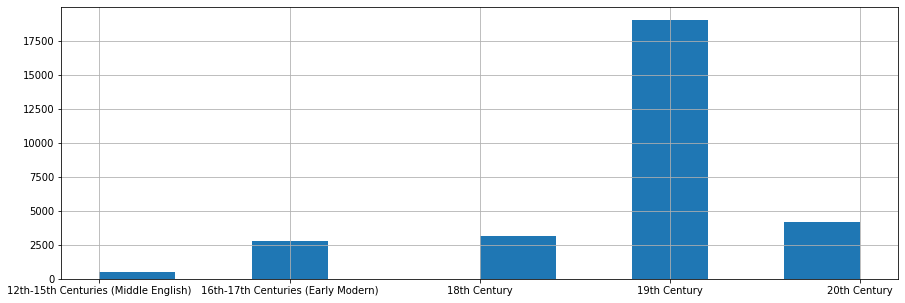

In [8]:
# Sort values, then create a histogram, and define the size of the figure
poetry_df['period'].sort_values().hist(figsize=(15, 5))

## **Sample text dataset**

Though we wish we could analyze all the poems in this data, non-Pro Colab tends to crash if we try to use more than 4-5,000 poems —  even with DistilBert, the smaller version of BERT. This is an important limitation to keep in mind if you want to experiment with BERT for your final project. 

For our purposes today, to reduce the number of poems into a managable amount, we will take a random sample of 1,000 poems from four different time periods: the 20th Century, 19th Century, 18th Century, and the Early Modern period.

In [9]:
# Filter the DataFrame for only a given time period, then randomly sample 1000 rows
nineteenth_sample = poetry_df[poetry_df['period'] == '19th Century'].sample(1000)
twentieth_sample = poetry_df[poetry_df['period'] == '20th Century'].sample(1000)
eighteenth_sample = poetry_df[poetry_df['period'] == '18th Century'].sample(1000)
sixteenth_sample = poetry_df[poetry_df['period'] == '16th-17th Centuries (Early Modern)'].sample(1000)

In [10]:
# Merge these random samples into a new DataFrame
poetry_df = pd.concat([sixteenth_sample, eighteenth_sample, twentieth_sample, nineteenth_sample])

In [11]:
poetry_df['period'].value_counts()

16th-17th Centuries (Early Modern)    1000
18th Century                          1000
20th Century                          1000
19th Century                          1000
Name: period, dtype: int64

Finally, let's make a list of poems from our Pandas DataFrame.

In [12]:
poetry_texts = poetry_df['text'].tolist()

Let's examine a poem in our dataset:

In [13]:
len(poetry_texts)

4000

In [14]:
print(poetry_texts[0])

Light Sonnets hence, and to loose Louers flie,
And mournfull Maydens sing an Elegie
On those three SHEFFIELDS, ouer-whelm'd with waues,
Whose losse the teares of all the Muses craues;
A thing so full of pitty as this was,
Me thinkes for nothing should not slightly passe.
Treble this losse was, why should it not borrowe,
Through this Iles treble parts, a treble sorrowe:
But Fate did this, to let the world to knowe,
That sorrowes which from common causes growe,
Are not worth mourning for, the losse to beare,
But of one onely sonne, 's not worth one teare.
Some tender-hearted man, as I, may spend
Some drops (perhaps) for a deceased friend.
Some men (perhaps) their Wifes late death may rue;
Or Wifes their Husbands, but such be but fewe.
Cares that haue vs'd the hearts of men to tuch
So oft, and deepely, will not now be such;
Who'll care for loss of maintenance, or place,
Fame, liberty, or of the Princes grace;
Or sutes in law, by base corruption crost,
When he shall finde, that this which 

## **Encode/tokenize text data for BERT**

Next we need to *encode* (or *tokenize*) our poems into the format that BERT (via Huggingface) will understand. We did this last class as well. 

As before, we'll tokenize the poems with the `tokenizer()` from HuggingFace's `DistilBertTokenizerFast`. Recall what the `tokenizer()` will do:

1. Truncate the texts if they're more than 512 tokens or pad them if they're fewer than 512 tokens. If a word is not in BERT's vocabulary, it will be broken up into smaller "word pieces," demarcated by a `##`.

2. Add in special tokens to help BERT:
    - [CLS] — Start token of every document
    - [SEP] — Separator between each sentence 
    - [PAD] — Padding at the end of the document as many times as necessary, up to 512 tokens
    - &#35;&#35; — Start of a "word piece" 

Here we will load `DistilBertTokenizerFast` from HuggingFace library, which will help us transform and encode the texts so they can be used with BERT.

In [15]:
from transformers import DistilBertTokenizerFast

In [16]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

The `tokenizer()` will break word tokens into word pieces, truncate to 512 tokens, and add padding and special BERT tokens.

In [17]:
tokenized_poems = tokenizer(poetry_texts, truncation=True, padding=True, return_tensors="pt")

Let's examine the first tokenized poem. We can see that the special BERT tokens have been inserted where necessary.

In [18]:
' '.join(tokenized_poems[0].tokens)

"[CLS] light son ##nets hence , and to loose lou ##ers fl ##ie , and mo ##urn ##ful ##l may ##den ##s sing an el ##eg ##ie on those three sheffield ##s , ou ##er - w ##helm ' d with wa ##ues , whose loss ##e the tear ##es of all the muse ##s cr ##au ##es ; a thing so full of pitt ##y as this was , me think ##es for nothing should not slightly pass ##e . tre ##ble this loss ##e was , why should it not borrow ##e , through this ile ##s tre ##ble parts , a tre ##ble sorrow ##e : but fate did this , to let the world to know ##e , that sorrow ##es which from common causes grow ##e , are not worth mourning for , the loss ##e to bear ##e , but of one one ##ly son ##ne , ' s not worth one tear ##e . some tender - hearted man , as i , may spend some drops ( perhaps ) for a deceased friend . some men ( perhaps ) their wife ##s late death may rue ; or wife ##s their husbands , but such be but few ##e . cares that ha ##ue vs ' d the hearts of men to tu ##ch so of ##t , and deep ##ely , will not no

<br><br>

## **Load pre-trained BERT model**

Here we will load a pre-trained BERT model. To speed things up we will use a GPU, but using GPU involves a few extra steps.
The command `.to("cuda")` moves data from regular memory to the GPU's memory.




In [19]:
from transformers import DistilBertModel

In [20]:
model = DistilBertModel.from_pretrained('distilbert-base-uncased').to("cuda")

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## **Get BERT word embeddings for each document in a collection**

To get word embeddings for all the words in our collection, we will use a basic `for` loop.

The process is as follows: for each poem in our list `poetry_texts`, we will tokenize the poem, and we will extract the vocabulary word ID for each word/token in the poem (to use for later reference). Then we will run the tokenized poem through the BERT model and extract the vectors for each word/token in the poem.

We thus create two big lists for all the poems in our collection — `doc_word_ids` and `doc_word_vectors`.

In [21]:
# List of vocabulary word IDs for all the words in each document (aka each poem)
doc_word_ids = []
# List of word vectors for all the words in each document (aka each poem)
doc_word_vectors = []

# Below we will slice our poem to ignore the first (0th) and last (-1) special BERT tokens
start_of_words = 1
end_of_words = -1

# Below we will index the 0th or first document, which will be the only document, since we're analzying one poem at a time
first_document = 0

for i, poem in enumerate(poetry_texts):
  
    # Here we tokenize each poem with the DistilBERT Tokenizer
    inputs = tokenizer(poem, return_tensors="pt", truncation=True, padding=True)

    # Here we extract the vocabulary word ids for all the words in the poem (the first or 0th document, since we only have one document)
    # We ignore the first and last special BERT tokens
    # We also convert from a Pytorch tensor to a numpy array
    doc_word_ids.append(inputs.input_ids[first_document].numpy()[start_of_words:end_of_words])

    # Here we send the tokenized poems to the GPU
    # The model is already on the GPU, but this poem isn't, so we send it to the GPU
    inputs.to("cuda")
    # Here we run the tokenized poem through the DistilBERT model
    outputs = model(**inputs)

    # We take every element from the first or 0th document, from the 2nd to the 2nd to last position
    # Grabbing the last layer is one way of getting token vectors. There are different ways to get vectors with different pros and cons
    doc_word_vectors.append(outputs.last_hidden_state[first_document,start_of_words:end_of_words,:].detach().cpu().numpy())


Confirm that we have the same number of documents for both the tokens and the vectors:

In [22]:
len(doc_word_ids), len(doc_word_vectors)

(4000, 4000)

In [23]:
doc_word_ids[0], doc_word_vectors[0]

(array([ 2422,  2365, 22781,  6516,  1010,  1998,  2000,  6065, 10223,
         2545, 13109,  2666,  1010,  1998,  9587, 14287,  3993,  2140,
         2089,  4181,  2015,  6170,  2019,  3449, 13910,  2666,  2006,
         2216,  2093,  8533,  2015,  1010, 15068,  2121,  1011,  1059,
        24546,  1005,  1040,  2007, 11333, 15808,  1010,  3005,  3279,
         2063,  1996,  7697,  2229,  1997,  2035,  1996, 18437,  2015,
        13675,  4887,  2229,  1025,  1037,  2518,  2061,  2440,  1997,
        15091,  2100,  2004,  2023,  2001,  1010,  2033,  2228,  2229,
         2005,  2498,  2323,  2025,  3621,  3413,  2063,  1012, 29461,
         3468,  2023,  3279,  2063,  2001,  1010,  2339,  2323,  2009,
         2025, 17781,  2063,  1010,  2083,  2023, 17869,  2015, 29461,
         3468,  3033,  1010,  1037, 29461,  3468, 14038,  2063,  1024,
         2021,  6580,  2106,  2023,  1010,  2000,  2292,  1996,  2088,
         2000,  2113,  2063,  1010,  2008, 14038,  2229,  2029,  2013,
      

In [24]:
# Take a look at the number of vectors for one of the words
len(doc_word_vectors[0])

510

## **Concatenate all word IDs/vectors for all documents**

Each element of these lists contains all the tokens/vectors for one document. But we want to concatenate them into two giant collections for ease of use.

In [25]:
all_word_ids = np.concatenate(doc_word_ids)
all_word_vectors = np.concatenate(doc_word_vectors, axis=0)

## **Computing Cosine Similarity**

Here's where we compute the *cosine similarity* of the vectors. Because cosine similarity measures the angle between vectors but ignores their length, we can speed this computation up by setting all the poem vectors to have length 1.0.

In [26]:
# Calculating the length of each vector (Pythagorean theorem)
row_norms = np.sqrt(np.sum(all_word_vectors ** 2, axis=1))
# Dividing every vector by its length
all_word_vectors /= row_norms[:,np.newaxis]

Now that we've normalized our vectors so that each has a length of 1, we can calculate the cosine similiarity between one vector and any other (or set of others) by taking the dot product of the two vectors. Here's a function we can write to do that: 


In [27]:
def get_nearest(query_vector, n=20):
  cosines = all_word_vectors.dot(query_vector)
  ordering = np.flip(np.argsort(cosines))
  return ordering[:n]

But, to make any results legible to humans, we need to be able to reattach these vectors to the words and contexts that they represent. Here are a bunch of functions that can help us do that:

## **Helpful functions** 

**Find all word positions in a collection**

This function uses the array `all_word_ids` to find all the places, or *positions*, in the collection where a word appears.

We'll do this with the `tokenizer.vocab` attribute, finding the word's vocab ID in BERT and then checking to see where/how many times this ID occurs in `all_word_ids`.

In [30]:
def get_word_positions(words):
  
  """This function accepts a list of words, rather than a single word"""

  # Get word/vocabulary ID from BERT for each word
  word_ids = [tokenizer.vocab[word] for word in words]

  # Find all the positions where the words occur in the collection
  word_positions = np.where(np.isin(all_word_ids, word_ids))[0]

  return word_positions

For example, we can check to see all the places where the word "bank" appears in the collection.

In [31]:
get_word_positions(["bank"])

array([ 66746,  72897, 100608, 169461, 187904, 207674, 225764, 229422,
       231391, 250608, 251003, 251012, 254951, 255088, 302917, 309066,
       334491, 336875, 345735, 357760, 357762, 379534, 386954, 387295,
       393477, 421576, 428023, 469488, 495967, 497092, 498494, 566272,
       568656, 617383, 617673, 686223, 725322, 728104, 730654, 759848,
       765254, 796510, 809885, 851601, 865075, 865077, 866623, 914442,
       930201, 930241, 938768, 940662, 940918, 946943, 975153, 978630])

**Use get_word_positions to find word from word position**

The above function allow us to determine all the positions where the word "bank" appears in the collection. But it would be more helpful to us as humans to know the actual words that appear in context around it. To find these context words, we have to convert position IDs back into words, like so:

In [32]:
# Here we create an array so that we can go backwards from numeric token IDs to words
word_lookup = np.empty(tokenizer.vocab_size, dtype="O")

for word, index in tokenizer.vocab.items():
    word_lookup[index] = word

Now we can use `word_lookup` to find a word based on its position in the collection. Let's first see what the output of a basic lookup operation looks like.

In [33]:
word_positions = get_word_positions(["bank"])

for word_position in word_positions:
  print(word_position, word_lookup[all_word_ids[word_position]])

66746 bank
72897 bank
100608 bank
169461 bank
187904 bank
207674 bank
225764 bank
229422 bank
231391 bank
250608 bank
251003 bank
251012 bank
254951 bank
255088 bank
302917 bank
309066 bank
334491 bank
336875 bank
345735 bank
357760 bank
357762 bank
379534 bank
386954 bank
387295 bank
393477 bank
421576 bank
428023 bank
469488 bank
495967 bank
497092 bank
498494 bank
566272 bank
568656 bank
617383 bank
617673 bank
686223 bank
725322 bank
728104 bank
730654 bank
759848 bank
765254 bank
796510 bank
809885 bank
851601 bank
865075 bank
865077 bank
866623 bank
914442 bank
930201 bank
930241 bank
938768 bank
940662 bank
940918 bank
946943 bank
975153 bank
978630 bank


But we're not done yet. We can modify the above code to look for the 3 words that come before "bank" and the 3 words that come after it.

In [34]:
word_positions = get_word_positions(["bank"])

for word_position in word_positions:

  # Slice 3 words before "bank"
  start_pos = word_position - 3
  # Slice 3 words after "bank"
  end_pos = word_position + 4

  context_words = word_lookup[all_word_ids[start_pos:end_pos]]
  # Join the words together
  context_words = ' '.join(context_words)
  print(word_position, context_words)

66746 then on the bank of jordan ,
72897 ? on sandy bank of late ,
100608 ##tty * * bank , the which
169461 cows ##lip - bank and shady willow
187904 residence at allan bank . the long
207674 bright gem every bank and trembling leaf
225764 sees but the bank that from thee
229422 , the blushing bank is all my
231391 ##no ' s bank , and on
250608 to the warm bank below , yellow
251003 " on a bank of flowers .
251012 . on a bank of flowers ,
254951 on a summer bank , to sing
255088 bends on the bank , amid the
302917 from the snowy bank the foot ##marks
309066 lily by the bank , the pri
334491 ##ted in a bank an ' clark
336875 ##s from the bank ' s green
345735 the gravel ##ly bank thrown up by
357760 , shooting from bank to bank ,
357762 from bank to bank , now in
379534 stood upon a bank , above her
386954 ! from what bank came those live
387295 on the green bank of clear al
393477 river ' s bank , in fable
421576 " see this bank - note -
428023 and the level bank of the swift
469488 an

Now that we've tested out this approach, let's make some functions that will help us get the context words around a certain word position for whatever size window (certain number of words before and after) that we want.

The first function `get_context()` will simply return the tokens without cleaning them, and the second function `get_context_clean()` will return the tokens in a more readable fashion. (Note the return of regex!) 

In [35]:
def get_context(word_id, window_size=10):
  
  """Simply get the tokens that occur before and after word position"""

  start_pos = max(0, word_id - window_size) # The token where we will start the context view
  end_pos = min(word_id + window_size + 1, len(all_word_ids)) # The token where we will end the context view

  # Make a list called tokens and use word_lookup to get the words for given token IDs from starting position up to the keyword
  tokens = [word_lookup[word] for word in all_word_ids[start_pos:end_pos] ]
  
  context_words = " ".join(tokens)

  return context_words

In [36]:
import re

def get_context_clean(word_id, window_size=10):
  
  """Get the tokens that occur before and after word position AND make them more readable"""

  keyword = word_lookup[all_word_ids[word_id]]
  start_pos = max(0, word_id - window_size) # The token where we will start the context view
  end_pos = min(word_id + window_size + 1, len(all_word_ids)) # The token where we will end the context view

  # Make a list called tokens and use word_lookup to get the words for given token IDs from starting position up to the keyword
  tokens = [word_lookup[word] for word in all_word_ids[start_pos:end_pos] ]
  
  # Make wordpieces slightly more readable
  # This is probably not the most efficient way to clean and correct for weird spacing
  context_words = " ".join(tokens)
  context_words = re.sub(r'\s+([##])', r'\1', context_words)
  context_words = re.sub(r'##', r'', context_words)
  context_words = re.sub('\s+\'s', '\'s', context_words)
  context_words = re.sub('\s+\'d', '\'d', context_words)
  context_words = re.sub('\s\'er', '\'er', context_words)
  context_words = re.sub(r'\s+([-,:?.!;])', r'\1', context_words)
  context_words = re.sub(r'([-\'"])\s+', r'\1', context_words)
  context_words = re.sub('\s+\'s', '\'s', context_words)
  context_words = re.sub('\s+\'d', '\'d', context_words)

  # Bold the keyword by putting asterisks around it
  if keyword in context_words:
    context_words = re.sub(f"\\b{keyword}\\b", f"**{keyword}**", context_words)
    context_words = re.sub(f"\\b({keyword}[esdtrlying]+)\\b", fr"**\1**", context_words)

  return context_words

## **Examining most similar vectors**

At long last, we're ready to perform our similarity comparison. First we need to decide which particular instance of "bank" we want to examine. Let's print out some instances of "bank" in our poetry corpus to see if one seems interesting to us. 



In [37]:
# load some libraries for displaying text nicely
from IPython.display import Markdown, display

def print_md(string):
    display(Markdown(string))

In [38]:
# print out instances of "bank" in the corpus
word_positions = get_word_positions(['bank'])

for word_position in word_positions:

  print_md(f"<br> {word_position}: {get_context_clean(word_position)} <br>")

<br> 66746: but return'd in vain. then on the **bank** of jordan, by a creek: where winds with <br>

<br> 72897: , to see me as you see? on sandy **bank** of late, i saw this woman sit; where <br>

<br> 100608: silver streaming themmes; whose rutty * * **bank**, the which his river hemmes, was pay <br>

<br> 169461: , in this sweet book, the cowslip-**bank** and shady willow-tree; and the fresh mead <br>

<br> 187904: grasmere, chiefly during our residence at allan **bank**. the long poem on my own education was, <br>

<br> 207674: thou seen a vernal morning bright gem every **bank** and trembling leaf with dews, tinging the <br>

<br> 225764: deride that shortsighted one sees but the **bank** that from thee is flying, not the one which <br>

<br> 229422: at th'shepherd's nose, the blushing **bank** is all my care, with hearth so red, <br>

<br> 231391: 's golden store, on arno's **bank**, and on that bloomy shore, warbling <br>

<br> 250608: ample numbers stray. ii. then to the warm **bank** below, yellow with the morning-ray, and <br>

<br> 251003: ireful mood. tune-"on a **bank** of flowers. "i. on a **bank** of <br>

<br> 251012: a **bank** of flowers. "i. on a **bank** of flowers, in a summer day, for summer <br>

<br> 254951: green abode, and, seated on a summer **bank**, to sing no earthly music; in a spot <br>

<br> 255088: ; from where the pensile birch bends on the **bank**, amid the clustered group of the dark hollie <br>

<br> 302917: they came. they follow'd from the snowy **bank** the footmarks, one by one, into the <br>

<br> 309066: t. iii. now blooms the lily by the **bank**, the primrose down the brae; <br>

<br> 334491: led a market, or strutted in a **bank** an 'clarkit my cash-account: while <br>

<br> 336875: of sweetest hue, young violets from the **bank**'s green side, and on poor mary ' <br>

<br> 345735: washed by the sea, or on the gravelly **bank** thrown up by wintry torrents roaring loud, <br>

<br> 357760: still water, with his dragon wings, shooting from **bank** to **bank**, now in quick turns, then swift <br>

<br> 357762: , with his dragon wings, shooting from **bank** to **bank**, now in quick turns, then swift athwa <br>

<br> 379534: a pheasant, as she stood upon a **bank**, above her brood; with pride maternal beat her <br>

<br> 386954: proof, though christian rites be wanting! from what **bank** came those live herbs? by what hand were they <br>

<br> 387295: , 'mid the circling wood, on the green **bank** of clear alb [ = u ] nea <br>

<br> 393477: [ 1 ] thus, on the river's **bank**, in fabled lore, the rustic stands; <br>

<br> 421576: , a senator addressing, said: "see this **bank**-note-lo! a blessing-breathe on <br>

<br> 428023: ious greeks, swept the foundation, and the level **bank** of the swift-rolling hellespont restored <br>

<br> 469488: oon of wood-doves sounds and moss-**banked** water flows, or musing late till the <br>

<br> 495967: where some sweet stream steals singing by a mossy **bank**; where violets vie in color with the summer <br>

<br> 497092: she turned her home with cod from george's **bank** when winds were blowing. and i know from that <br>

<br> 498494: shouted: "check! "stretched on a sunny **bank** he lay at rest, ferns at his elbow, <br>

<br> 566272: mists that cloak hanger and hollied **bank**, the winter world awoke to hear the feeble <br>

<br> 568656: , william, the head-clerk in the county **bank**, and henry, a stock-broker, doing <br>

<br> 617383: a buttercup bright, and our shrine is a **bank** of sod, but still we share st. <br>

<br> 617673: a buttercup bright, and our shrine is a **bank** of sod, but still we share st. <br>

<br> 686223: helping to land old thomas rhodes for wrecking the **bank**, and the judge was a friend of rhodes and <br>

<br> 725322: low and crank, the little shallop from strawberry **bank**; and he rose in his stirrups and <br>

<br> 728104: birth, couched like a king each on its **bank** of earth arbalist, manganel and cat <br>

<br> 730654: the latvians all have led.-upon the **bank** once stood by kegums town, of lie <br>

<br> 759848: . look westward bears the blue no brown cloud-**bank**? nay, it is written wherefore should <br>

<br> 765254: other at their ease. while 'neath the **bank** on which he rests his head the brook mourn <br>

<br> 796510: . then the indians prayed the spirits haunting river, **bank**, and hill, to let hatred, like marsh <br>

<br> 809885: 's daughter, and later became president of the **bank**-always looking forward to some leisure to write an <br>

<br> 851601: with his rage no common foe; for pebbly **bank**, nor sand-bed here, nor clay- <br>

<br> 865075: or glee, through bay on bay shone blind from **bank** to **bank** the weary mediterranean, drear to see <br>

<br> 865077: , through bay on bay shone blind from **bank** to **bank** the weary mediterranean, drear to see. more <br>

<br> 866623: many an ancient tale of love a romeo garden, **banked** with bloom, and trellised with the <br>

<br> 914442: of that old and sweet refrain. such a starved **bank** of moss till, that may-morn, <br>

<br> 930201: faces in a dream. two knelt down upon the **bank** and of that dark water drank. but the third <br>

<br> 930241: each other, then side by side, upon the **bank**, in a bed of poppies sank. ' <br>

<br> 938768: n'd clusters down. while, on a **bank** of faded grass, some artless maid the prize <br>

<br> 940662: which our old traditions tell. for here the upland **bank** sends out a ridge toward the river-side; <br>

<br> 940918: wolf, and grapple with the bear. this **bank**, in which the dead were laid, was sacred <br>

<br> 946943: there was not cursings ne adventure of death blinded **bankes** betweene, but good-fellowship of yo <br>

<br> 975153: , nor in a snug sum in a **bank**. some may say ther's noa <br>

<br> 978630: water to bathe; he stood naked upon the **bank**. his breast was like a white cloud in the <br>

Now we can pick any of these keyword positions to compare to.

In [39]:
keyword_position = 613260 # can be replaced with any of the above

And at long last, display the most similar vectors

In [40]:
contexts = [get_context_clean(token_id) for token_id in get_nearest(all_word_vectors[keyword_position,:])]

for context in contexts:
  print_md(context)

a game for a winter's night! slower **now**, slower **now**, softer the music sighs; look

a winter's night! slower **now**, slower **now**, softer the music sighs; look, there are

to fall and bleed! their voices rouse no echo **now**, their footsteps have no speed; they sleep,

's put on his guard, greenhide descending **now**, sharp reports blending **now**, flogging her

from his delight. o leaves, so quietly ending **now**, you have heard cuckoos sing. and i

bosom's touch. the flowers blooming **now** will pass, and strew the grass, and

apples from the bending boughs: a soldier **now**, he with his sword appears; a fisher next

fast, and days dragged slow. but joyful **now**, with eager eye, fast to the promised land

trips. start: how's time? soon **now**. two minutes or less. the gun's

had dropt from grief, and jealousy would, **now** and then, ruffle in haste some snow-

guard, greenhide descending **now**, sharp reports blending **now**, flogging her back up the wings of

's cup of nectar tasting thou'st wasted **now**! up, up!-the master's

may'st praise or blame. as people marry **now** and settle, fierce love abates his usual met

as light and just as yellow; there are many **now**, **now** one **now** they stop and there are none

their vow... why go the south road **now**? why go any road **now**? white stands the

, the plaint, the sighing, come even **now**. rise! gird thyself;-

that lies as hurled, that lies unlifted **now**, come dew, come rust, but still lies

us, alas, lieth the golden age **now**! for by philosophers spoiled is our language our logic

-descried, waiting the signal-word **now**, christian, **now**! 1. mine eyes were

with delight to be living and free: free utterly **now**, though the freedom endure but the space of a

## **Reduce word vectors via PCA and plot them**

We don't need to just *read* examples of similar usages of "bank" in the collection, we can also visualize them. 

But to do so, we need to perform some dimensionality reduction. Previously, we've used t-SNE for this purpose. Here, for variety's sake, we will use PCA. 

In [41]:
from sklearn.decomposition import PCA

word_positions = get_word_positions(["bank"])

pca = PCA(n_components=2)

pca.fit(all_word_vectors[word_positions,:].T)

PCA(n_components=2)

Let's now make a list of all of the context views for our keyword so that we can associate them with their PCA score:

In [42]:
word_positions = get_word_positions(["bank"])

keyword_contexts = []
keyword_contexts_tokens = []

for position in word_positions:

  keyword_contexts.append(get_context_clean(position))
  keyword_contexts_tokens.append(get_context(position))

Then, for convenience, we will put these PCA results into a Pandas DataFrame, which will use to generate an interactive plot.

In [43]:
df = pd.DataFrame({"x": pca.components_[0,:], "y": pca.components_[1,:],
                   "context": keyword_contexts, "tokens": keyword_contexts_tokens})
df.head()

,x,y,context,tokens
0,-0.135220,0.177339,"but return'd in vain. then on the **bank** of jordan, by a creek: where winds with","but return ' d in vain . then on the bank of jordan , by a creek : where winds with"
1,-0.133464,0.147855,", to see me as you see? on sandy **bank** of late, i saw this woman sit; where",", to see me as you see ? on sandy bank of late , i saw this woman sit ; where"
2,-0.135126,-0.010424,"silver streaming themmes; whose rutty * * **bank**, the which his river hemmes, was pay","silver streaming them ##mes ; whose ru ##tty * * bank , the which his river hem ##mes , was pay"
3,-0.135782,-0.009955,", in this sweet book, the cowslip-**bank** and shady willow-tree; and the fresh mead",", in this sweet book , the cows ##lip - bank and shady willow - tree ; and the fresh mead"
4,-0.113406,-0.096013,"grasmere, chiefly during our residence at allan **bank**. the long poem on my own education was,","gr ##as ##mere , chiefly during our residence at allan bank . the long poem on my own education was ,"


## **Match context with original text and metadata** 

It's helpful (and fun!) to know where each instance of a word actually comes from — which poem, which poet, which time period, which Public-Domain-Poetry.com web page. The easiest method we've found for matching a bit of context with its original poem and metdata is to 1) add a tokenized version of each poem to our original Pandas Dataframe 2) check to see if the context shows up in a poem 3) and if so, grab the original poem and metadata.

In [44]:
# Tokenize all the poems
tokenized_poems = tokenizer(poetry_texts, truncation=True, padding=True, return_tensors="pt")

# Get a list of all the tokens for each poem
all_tokenized_poems = []
for i in range(len(tokenized_poems['input_ids'])):
  all_tokenized_poems.append(' '.join(tokenized_poems[i].tokens))

# Add them to the original DataFrame
poetry_df['tokens'] = all_tokenized_poems

In [45]:
poetry_df.head(2)

,author,title,text,lifespan,birth_year,death_year,link,period,tokens
16826,Michael Drayton,"Vpon The Three Sonnes Of The Lord Sheffield, Drowned In Hvmber","Light Sonnets hence, and to loose Louers flie,\r\nAnd mournfull Maydens sing an Elegie\r\nOn those three SHEFFIELDS, ouer-whelm'd with waues,\r\nWhose losse the teares of all the Muses craues;\r\n...","1563-December 23, 1631",1563.0,1631.0,http://public-domain-poetry.com/michael-drayton/vpon-the-three-sonnes-of-the-lord-sheffield-drowned-in-hvmber-14566,16th-17th Centuries (Early Modern),"[CLS] light son ##nets hence , and to loose lou ##ers fl ##ie , and mo ##urn ##ful ##l may ##den ##s sing an el ##eg ##ie on those three sheffield ##s , ou ##er - w ##helm ' d with wa ##ues , whos..."
19099,Philip Sidney (Sir),Astrophel and Stella - Sonnet LIX,"Deere, why make you more of a dog then me?\r\nIf he doe loue, I burne, I burne in loue;\r\nIf he waite well, I neuer thence would moue;\r\nIf he be faire, yet but a dog can be;\r\nLittle he is, so...",30 November 1554-17 October 1586,1554.0,1586.0,http://public-domain-poetry.com/sir-philip-sidney/astrophel-and-stella-sonnet-lix-31890,16th-17th Centuries (Early Modern),"[CLS] deer ##e , why make you more of a dog then me ? if he doe lou ##e , i burn ##e , i burn ##e in lou ##e ; if he wait ##e well , i neue ##r thence would mo ##ue ; if he be fair ##e , yet but a..."


In [46]:
def find_original_poem(rows):

  """This function checks to see whether the context tokens show up in the original poem,
  and if so, returns metadata about the title, author, period, and URL for that poem"""

  text = rows['tokens'].replace('**', '')
  text = text[55:70]

  if poetry_df['tokens'].str.contains(text, regex=False).any() == True :
    row = poetry_df[poetry_df['tokens'].str.contains(text, regex=False)].values[0]
    title, author, period, link = row[0], row[1], row[7], row[6]
    return author, title, period, link
  else:
    return None, None, None, None

In [47]:
df[['title', 'author', 'period', 'link']] = df.apply(find_original_poem, axis='columns', result_type='expand')

In [48]:
df

,x,y,context,tokens,title,author,period,link
0,-0.135220,0.177339,"but return'd in vain. then on the **bank** of jordan, by a creek: where winds with","but return ' d in vain . then on the bank of jordan , by a creek : where winds with",Paradise Regained - The Second Book,John Milton,16th-17th Centuries (Early Modern),http://public-domain-poetry.com/john-milton/paradise-regained-the-second-book-8323
1,-0.133464,0.147855,", to see me as you see? on sandy **bank** of late, i saw this woman sit; where",", to see me as you see ? on sandy bank of late , i saw this woman sit ; where",Translation,Philip Sidney (Sir),16th-17th Centuries (Early Modern),http://public-domain-poetry.com/sir-philip-sidney/translation-31823
2,-0.135126,-0.010424,"silver streaming themmes; whose rutty * * **bank**, the which his river hemmes, was pay","silver streaming them ##mes ; whose ru ##tty * * bank , the which his river hem ##mes , was pay","Prothalamion: Or, A Spousall Verse",Edmund Spenser,16th-17th Centuries (Early Modern),http://public-domain-poetry.com/edmund-spenser/prothalamion-or-a-spousall-verse-32239
3,-0.135782,-0.009955,", in this sweet book, the cowslip-**bank** and shady willow-tree; and the fresh mead",", in this sweet book , the cows ##lip - bank and shady willow - tree ; and the fresh mead","Written Upon A Blank Leaf In ""The Complete Angler.""",William Wordsworth,18th Century,http://public-domain-poetry.com/william-wordsworth/written-upon-a-blank-leaf-in-the-complete-angler-4241
4,-0.113406,-0.096013,"grasmere, chiefly during our residence at allan **bank**. the long poem on my own education was,","gr ##as ##mere , chiefly during our residence at allan bank . the long poem on my own education was ,",The Excursion. Note & Preface,William Wordsworth,18th Century,http://public-domain-poetry.com/william-wordsworth/excursion-note-preface-4208
5,-0.134207,-0.003791,"thou seen a vernal morning bright gem every **bank** and trembling leaf with dews, tinging the","thou seen a ve ##rna ##l morning bright gem every bank and trembling leaf with dew ##s , ting ##ing the",The Missionary. Canto Fifth,William Lisle Bowles,18th Century,http://public-domain-poetry.com/william-lisle-bowles/missionary-canto-fifth-9433
6,-0.127120,-0.092797,"deride that shortsighted one sees but the **bank** that from thee is flying, not the one which","der ##ide that shorts ##ight ##ed one sees but the bank that from thee is flying , not the one which",Wisdom And Prudence,Friedrich Schiller,18th Century,http://public-domain-poetry.com/friedrich-schiller/wisdom-and-prudence-30575
7,-0.132556,-0.137386,"at th'shepherd's nose, the blushing **bank** is all my care, with hearth so red,","at th ' shepherd ' s nose , the blushing bank is all my care , with hearth so red ,",Blind Man's Buff,William Blake,18th Century,http://public-domain-poetry.com/william-blake/blind-mans-buff-9293
8,-0.139993,-0.008247,"'s golden store, on arno's **bank**, and on that bloomy shore, warbling","' s golden store , on ar ##no ' s bank , and on that bloom ##y shore , war ##bling",Sonnet LXXV. Subject Continued,Anna Seward,18th Century,http://public-domain-poetry.com/anna-seward/sonnet-lxxv-subject-continued-31165
9,-0.140098,0.133744,"ample numbers stray. ii. then to the warm **bank** below, yellow with the morning-ray, and","ample numbers stray . ii . then to the warm bank below , yellow with the morning - ray , and","Odes From Horace. - [1]On The Pleasures Of Rural Life. Book The Fifth, Epode The Second",Anna Seward,18th Century,http://public-domain-poetry.com/anna-seward/odes-from-horace-1on-the-pleasures-of-rural-life-book-the-fifth-epode-the-second-31214


## **Plot word embeddings**

Lastly, we will plot the words vectors from this DataFrame with the Python data viz library [Altair](https://altair-viz.github.io/gallery/scatter_tooltips.html).

In [49]:
import altair as alt

In [50]:
alt.Chart(df,title="Word Similarity: Bank").mark_circle(size=200).encode(
    alt.X('x',
        scale=alt.Scale(zero=False)
    ), y="y",
    # If you click a point, take you to the URL link 
    href="link",
    # The categories that show up in the hover tooltip
    tooltip=['title', 'context', 'author', 'period']
    ).interactive().properties(
    width=500,
    height=500
)

alt.Chart(...)

## **Plot word embeddings from keywords (all at once!)**

We can put the code from the previous few sections into a single cell and plot the BERT word embeddings for any list of words. Let's look at the words "nature," "religion," "science," and "art."

In [51]:
# List of keywords that you want to compare
keywords = ['nature', 'religion', 'science', 'art']

# How to color the points in the plot. The other option is "period" for time period
color_by = 'word'

# Get all word positions
word_positions = get_word_positions(keywords)

# Get all contexts around the words
keyword_contexts = []
keyword_contexts_tokens = []
words = []

for position in word_positions:
  words.append(word_lookup[all_word_ids[position]])
  keyword_contexts.append(get_context_clean(position))
  keyword_contexts_tokens.append(get_context(position))

# Reduce word vectors with PCA
pca = PCA(n_components=2)
pca.fit(all_word_vectors[word_positions,:].T)

# Make a DataFrame with PCA results
df = pd.DataFrame({"x": pca.components_[0,:], "y": pca.components_[1,:],
                   "context": keyword_contexts, "tokens": keyword_contexts_tokens, "word": words})
# Match original text and metadata
df[['title', 'author', 'period', 'link']] = df.apply(find_original_poem, axis='columns', result_type='expand')

# Rename columns so that the context shows up as the "title" in the tooltip (bigger and bolded)
df = df.rename(columns={'title': 'poem_title', 'context': 'title'})

# Make the plot
alt.Chart(df, title=f"Word Similarity: {', '.join(keywords).title()}").mark_circle(size=200).encode(
    alt.X('x',
        scale=alt.Scale(zero=False)
    ), y="y",
    color= color_by,
    href="link",
    tooltip=['title', 'word', 'poem_title', 'author', 'period']
    ).interactive().properties(
    width=500,
    height=500
)

alt.Chart(...)

Let's examine the words "nature," "religion," "science," and "art" again but this time color the points by their time period.

In [52]:
# List of keywords that you want to compare
keywords = ['nature', 'religion', 'science', 'art']

# How to color the points in the plot
color_by = 'period' 

# Get all word positions
word_positions = get_word_positions(keywords)

# Get all contexts around the words
keyword_contexts = []
keyword_contexts_tokens = []
words = []

for position in word_positions:
  words.append(word_lookup[all_word_ids[position]])
  keyword_contexts.append(get_context_clean(position))
  keyword_contexts_tokens.append(get_context(position))

# Reduce word vectors with PCA
pca = PCA(n_components=2)
pca.fit(all_word_vectors[word_positions,:].T)

# Make a DataFrame with PCA results
df = pd.DataFrame({"x": pca.components_[0,:], "y": pca.components_[1,:],
                   "context": keyword_contexts, "tokens": keyword_contexts_tokens, "word": words})
# Match original text and metadata
df[['title', 'author', 'period', 'link']] = df.apply(find_original_poem, axis='columns', result_type='expand')

# Rename columns so that the context shows up as the "title" in the tooltip (bigger and bolded)
df = df.rename(columns={'title': 'poem_title', 'context': 'title'})

# Make the plot
alt.Chart(df, title=f"Word Similarity: {', '.join(keywords).title()}").mark_circle(size=200).encode(
    alt.X('x',
        scale=alt.Scale(zero=False)
    ), y="y",
    color= 'period',
    href="link",
    tooltip=['title', 'word', 'poem_title', 'author', 'period']
    ).interactive().properties(
    width=500,
    height=500
)

alt.Chart(...)

Let's compare the words "mean," "thin," "average", and "cruel."

In [53]:
# List of keywords that you want to compare
keywords = ['mean', 'thin', 'average', 'cruel']

# How to color the points in the plot. The other option is "period" for time period
color_by = 'word'

# Get all word positions
word_positions = get_word_positions(keywords)

# Get all contexts around the words
keyword_contexts = []
keyword_contexts_tokens = []
words = []

for position in word_positions:
  words.append(word_lookup[all_word_ids[position]])
  keyword_contexts.append(get_context_clean(position))
  keyword_contexts_tokens.append(get_context(position))

# Reduce word vectors with PCA
pca = PCA(n_components=2)
pca.fit(all_word_vectors[word_positions,:].T)

# Make a DataFrame with PCA results
df = pd.DataFrame({"x": pca.components_[0,:], "y": pca.components_[1,:],
                   "context": keyword_contexts, "tokens": keyword_contexts_tokens, "word": words})
# Match original text and metadata
df[['title', 'author', 'period', 'link']] = df.apply(find_original_poem, axis='columns', result_type='expand')

# Rename columns so that the context shows up as the "title" in the tooltip (bigger and bolded)
df = df.rename(columns={'title': 'poem_title', 'context': 'title'})

# Make the plot
alt.Chart(df, title=f"Word Similarity: {', '.join(keywords).title()}").mark_circle(size=200).encode(
    alt.X('x',
        scale=alt.Scale(zero=False)
    ), y="y",
    color= color_by,
    href="link",
    tooltip=['title', 'word', 'poem_title', 'author', 'period']
    ).interactive().properties(
    width=500,
    height=500
)

alt.Chart(...)

Let's compare the words 'head', 'heart', 'eye', 'arm', and 'leg.'

In [54]:
# List of keywords that you want to compare
keywords = ['head', 'heart', 'eye', 'arm', 'leg']

# How to color the points in the plot. The other option is "period" for time period
color_by = 'word'

# Get all word positions
word_positions = get_word_positions(keywords)

# Get all contexts around the words
keyword_contexts = []
keyword_contexts_tokens = []
words = []

for position in word_positions:
  words.append(word_lookup[all_word_ids[position]])
  keyword_contexts.append(get_context_clean(position))
  keyword_contexts_tokens.append(get_context(position))

# Reduce word vectors with PCA
pca = PCA(n_components=2)
pca.fit(all_word_vectors[word_positions,:].T)

# Make a DataFrame with PCA results
df = pd.DataFrame({"x": pca.components_[0,:], "y": pca.components_[1,:],
                   "context": keyword_contexts, "tokens": keyword_contexts_tokens, "word": words})
# Match original text and metadata
df[['title', 'author', 'period', 'link']] = df.apply(find_original_poem, axis='columns', result_type='expand')

# Rename columns so that the context shows up as the "title" in the tooltip (bigger and bolded)
df = df.rename(columns={'title': 'poem_title', 'context': 'title'})

# Make the plot
alt.Chart(df, title=f"Word Similarity: {', '.join(keywords).title()}").mark_circle(size=200).encode(
    alt.X('x',
        scale=alt.Scale(zero=False)
    ), y="y",
    color= color_by,
    href="link",
    tooltip=['title', 'word', 'poem_title', 'author', 'period']
    ).interactive().properties(
    width=500,
    height=500
)

alt.Chart(...)

In [55]:
# List of keywords that you want to compare
keywords = ['ring', 'crown']

# How to color the points in the plot. The other option is "period" for time period
color_by = 'word'

# Get all word positions
word_positions = get_word_positions(keywords)

# Get all contexts around the words
keyword_contexts = []
keyword_contexts_tokens = []
words = []

for position in word_positions:
  words.append(word_lookup[all_word_ids[position]])
  keyword_contexts.append(get_context_clean(position))
  keyword_contexts_tokens.append(get_context(position))

# Reduce word vectors with PCA
pca = PCA(n_components=2)
pca.fit(all_word_vectors[word_positions,:].T)

# Make a DataFrame with PCA results
df = pd.DataFrame({"x": pca.components_[0,:], "y": pca.components_[1,:],
                   "context": keyword_contexts, "tokens": keyword_contexts_tokens, "word": words})
# Match original text and metadata
df[['title', 'author', 'period', 'link']] = df.apply(find_original_poem, axis='columns', result_type='expand')

# Rename columns so that the context shows up as the "title" in the tooltip (bigger and bolded)
df = df.rename(columns={'title': 'poem_title', 'context': 'title'})

# Make the plot
alt.Chart(df, title=f"Word Similarity: {', '.join(keywords).title()}").mark_circle(size=200).encode(
    alt.X('x',
        scale=alt.Scale(zero=False)
    ), y="y",
    color= color_by,
    href="link",
    tooltip=['title', 'word', 'poem_title', 'author', 'period']
    ).interactive().properties(
    width=500,
    height=500
)

alt.Chart(...)

## **Go from PCA (or t-SNE) to "sense clusters"**

[ Link to Lucy's slides ](https://docs.google.com/presentation/d/1yTupYj9g78XfbOqN9hSF33xdi5eiFgZZBVVK46SNKp8/edit#slide=id.gd6f9574c10_0_296)

In [56]:
df.to_csv('bert-word-ring.csv', index=False, encoding='utf-8')